In [1]:
%matplotlib widget
#%matplotlib inline

In [2]:
# initialization
from rayoptics.environment import *

In [3]:
import pprint
import json

In [4]:
root_pth = Path(rayoptics.__file__).resolve().parent

In [5]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

### Define first order aperture and field for model

In [6]:
osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=1.)
osp.field_of_view = FieldSpec(osp, key=['object', 'angle'], flds=[0.])
osp.spectral_region = WvlSpec([(555.0, 1.0)], ref_wl=0)

### Enter sequential model

In [7]:
opm.radius_mode = True

sm.gaps[0].thi=1e10

opm.add_dummy_plane(t=5.0)
sm.set_stop()

opm.add_mirror(t=-5.0)
sm.ifcs[2].decenter = srf.DecenterData('bend', alpha=15.)

opm.add_mirror(t=7.5)
sm.ifcs[3].decenter = srf.DecenterData('bend', alpha=-15.)

opm.add_mirror(t=-5.0)
sm.ifcs[4].decenter = srf.DecenterData('bend', alpha=-45.)

In [8]:
opm.update_model()

In [9]:
sm.list_model()
print('')
sm.list_decenters()

              r            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      0.0000
 Stop:     0.000000      5.00000       air             1     0.50000
    2:     0.000000     -5.00000       air    reflect -1     0.51764
    3:     0.000000      7.50000       air    reflect  1     0.51764
    4:     0.000000     -5.00000       air    reflect -1     0.70711
  Img:    -0.000000      0.00000                      -1     0.50000

              thi    medium/mode          type          y       alpha
    0:  1.00000e+10          air
    1:      5.00000          air
    2:                   reflect            bend     0.0000     15.000
    2:     -5.00000          air
    3:                   reflect            bend     0.0000    -15.000
    3:      7.50000          air
    4:                   reflect            bend     0.0000    -45.000
    4:     -5.00000          air
    5:                     dummy


In [10]:
opm.specsheet.imager

IdealImager(m=None, s=-inf, sp=None, tt=None, f=None)

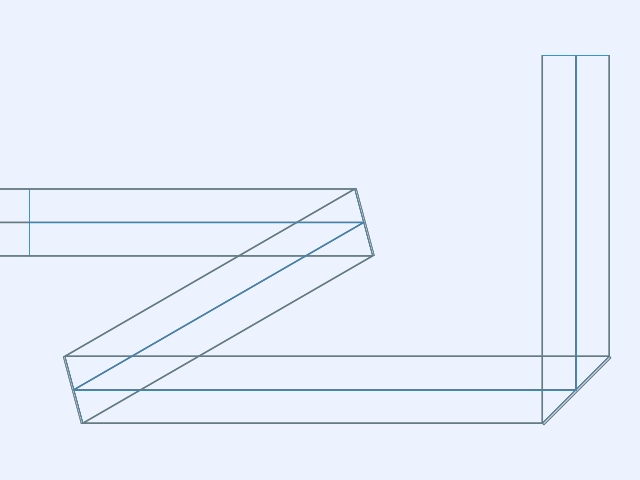

In [11]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=False, do_paraxial_layout=False,
                        refresh_gui=None).plot()

In [12]:
pt.list_model()

root
├── Object
├── D1
├── M1
├── M2
├── M3
└── Image


In [13]:
em.list_elements()

0: Object (DummyInterface): Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy')
1: Object space (AirGap): Gap(t=10000000000.0, medium=Air())
2: D1 (DummyInterface): Surface(profile=Spherical(c=0.0), interact_mode='transmit')
3: AG1 (AirGap): Gap(t=5.0, medium=Air())
4: M1 (Mirror): Mirror: Spherical(c=0.0), t=0.0259, sd=0.5176
5: AG2 (AirGap): Gap(t=-5.0, medium=Air())
6: M2 (Mirror): Mirror: Spherical(c=0.0), t=0.0259, sd=0.5176
7: AG3 (AirGap): Gap(t=7.5, medium=Air())
8: M3 (Mirror): Mirror: Spherical(c=0.0), t=0.0354, sd=0.7071
9: Image space (AirGap): Gap(t=-5.0, medium=Air())
10: Image (DummyInterface): Surface(lbl='Img', profile=Spherical(c=-0.0), interact_mode='dummy')


In [14]:
for i,e in enumerate(em.elements):
    if hasattr(e, 'get_thi'):
        print(i, e.get_thi(), e.z_dir, sm.z_dir[e.reference_idx()], e.reference_interface().normal(np.array([0., 0., 0.])))

4 0.025881904523539785 -1.0 -1.0 [-0. -0.  1.]
6 0.02588190453648074 1.0 1.0 [-0. -0.  1.]
8 0.035355339122966956 -1.0 -1.0 [-0. -0.  1.]


In [15]:
for i,trfm in enumerate(sm.gbl_tfrms):
    print("{}: {:12.7g} {:12.7g} {:12.7g}".format(i, trfm[1][0], trfm[1][1], trfm[1][2]))

0:            0            0       -1e+10
1:            0            0            0
2:            0            0            5
3:            0         -2.5     0.669873
4:            0         -2.5     8.169873
5:            0          2.5     8.169873


In [16]:
pt0 = np.array([0., 0., 0.])
dir0 = np.array([0., 0., 1.])
wvl = sm.central_wavelength()
oar = rt.trace(sm, pt0, dir0, wvl)
list_ray(oar[0])

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+10
  1:      0.00000      0.00000            0     0.000000     0.000000     1.000000            5
  2:      0.00000      0.00000            0     0.000000    -0.258819    -0.965926            5
  3:      0.00000      0.00000            0     0.000000    -0.258819     0.965926          7.5
  4:      0.00000     -0.00000            0     0.000000     0.707107    -0.707107            5
  5:      0.00000     -0.00000            0     0.000000    -0.000000    -1.000000            0


In [17]:
tfrms = sm.gbl_tfrms
print("            X            Y            Z        z_dir     SRL"
      "          SRM          SRN")
for i, r in enumerate(oar[mc.ray][0:]):
    rot, trns = tfrms[i]
    p = rot.dot(r[mc.p]) + trns
    snr = rot.dot(r[mc.nrml])
    try:
        z_dir = sm.z_dir[i]
    except:
        z_dir = sm.z_dir[i-1]
    print("{:3d}: {:12.5f} {:12.5f} {:12.5g}   {:4.0f} {:12.6f} {:12.6f} {:12.6f}"
          .format(i, p[0], p[1], p[2], z_dir, snr[0], snr[1], snr[2]))

            X            Y            Z        z_dir     SRL          SRM          SRN
  0:      0.00000      0.00000       -1e+10      1     0.000000     0.000000     1.000000
  1:      0.00000      0.00000            0      1     0.000000     0.000000     1.000000
  2:      0.00000      0.00000            5     -1     0.000000     0.258819     0.965926
  3:      0.00000     -2.50000      0.66987      1     0.000000     0.258819     0.965926
  4:      0.00000     -2.50000       8.1699     -1     0.000000    -0.707107     0.707107
  5:      0.00000      2.50000       8.1699     -1     0.000000    -1.000000     0.000000


In [18]:
list_ray(oar,tfrms=sm.gbl_tfrms)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000       -1e+10     0.000000     0.000000     1.000000        1e+10
  1:      0.00000      0.00000            0     0.000000     0.000000     1.000000            5
  2:      0.00000      0.00000            5     0.000000    -0.500000    -0.866025            5
  3:      0.00000     -2.50000      0.66987     0.000000     0.000000     1.000000          7.5
  4:      0.00000     -2.50000       8.1699     0.000000     1.000000    -0.000000            5
  5:      0.00000      2.50000       8.1699     0.000000     1.000000    -0.000000            0


In [19]:
sm.z_dir

[1.0, 1.0, -1.0, 1.0, -1.0]

In [20]:
sm.list_decenters()

              thi    medium/mode          type          y       alpha
    0:  1.00000e+10          air
    1:      5.00000          air
    2:                   reflect            bend     0.0000     15.000
    2:     -5.00000          air
    3:                   reflect            bend     0.0000    -15.000
    3:      7.50000          air
    4:                   reflect            bend     0.0000    -45.000
    4:     -5.00000          air
    5:                     dummy


In [21]:
opm.save_model('Tilted mirrors')

In [22]:
opm = open_model(root_pth/"codev/tests/folded_lenses.seq")
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ss = opm['specsheet']

In [23]:
sm.list_model()
print('')
sm.list_decenters()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
    1:     0.000000      5.00000       air             1     0.50000
    2:     0.000000     -2.25000       air    reflect -1      1.0000
    3:    -0.670000    -0.300000     N-BK7            -1     0.50000
    4:     0.000000   -0.0500000       air            -1     0.47441
    5:     0.000000    -0.200000     N-BK7            -1     0.46524
    6:    -0.770950     -2.25000       air            -1     0.43242
    7:     0.000000      2.25000       air    reflect  1     0.86202
    8:    -0.670000     0.200000     N-BK7             1     0.42812
    9:     0.000000    0.0500000       air             1     0.45454
   10:     0.000000     0.300000     N-BK7             1     0.46223
   11:    -0.592250      2.25000       air             1     0.48523
   12:     0.000000     -5.00000       air    reflect -1     0.68285
  Img:     0.000000      0.00000     

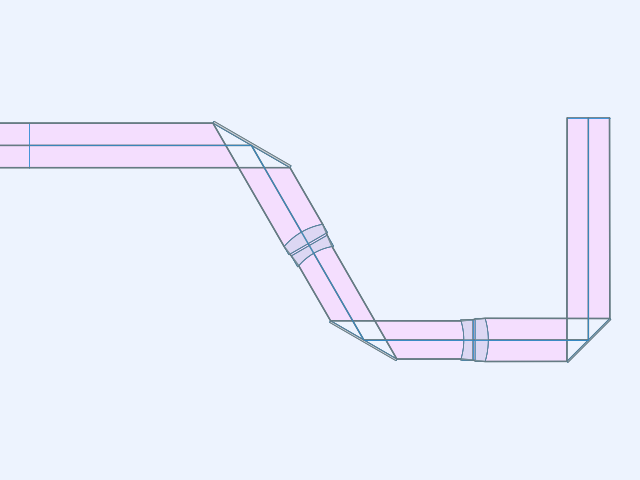

In [24]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False,
                        refresh_gui=None).plot()
#layout_plt.update_data()
#layout_plt.plot()

In [25]:
pm.first_order_data()

efl                2564
ffl               -2600
pp1              -35.67
bfl                2615
ppk              -51.08
f/#                2564
m            -2.564e-08
red            -3.9e+07
obj_dist          1e+11
obj_ang               1
enp_dist             -0
enp_radius          0.5
na obj            5e-12
n obj                 1
img_dist          -2513
img_ht            44.76
exp_dist          -2492
exp_radius       0.4931
na img         0.000195
n img                -1
optical invariant     0.008728


In [26]:
print(json.dumps(ss.imager_inputs))

{"s": -Infinity}


In [27]:
pprint.pprint(ss.etendue_values['field'], indent=4)

{'image': {'height': 0.0}, 'object': {'angle': 0.0}}


In [28]:
ss.conjugate_type

'infinite'

In [29]:
ss.partition_defined()

(None, 1)

In [30]:
for i,s in enumerate(sm.ifcs):
    try:
        z_dir = sm.z_dir[i]
    except:
        z_dir = sm.z_dir[i-1]
    print(i, z_dir, s.profile_cv)

0 1.0 0.0
1 1.0 0.0
2 -1.0 0.0
3 -1.0 -0.67
4 -1.0 0.0
5 -1.0 0.0
6 -1.0 -0.77095
7 1.0 0.0
8 1.0 -0.67
9 1.0 0.0
10 1.0 0.0
11 1.0 -0.59225
12 -1.0 0.0
13 -1.0 0.0


In [31]:
pt.list_model()

root
├── Object
├── D2
├── M4
├── E1
├── E2
├── M5
├── E3
├── E4
├── M6
└── Image


In [32]:
em.list_elements()

0: Object (DummyInterface): Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy')
1: Object space (AirGap): Gap(t=100000000000.0, medium=Air())
2: D2 (DummyInterface): Surface(profile=Spherical(c=0.0), interact_mode='transmit')
3: AG4 (AirGap): Gap(t=5.0, medium=Air())
4: M4 (Mirror): Mirror: Spherical(c=0.0), t=0.0500, sd=1.0000
5: AG5 (AirGap): Gap(t=-2.25, medium=Air())
6: E1 (Element): Element: Spherical(c=-0.67), Spherical(c=0.0), t=-0.3000, sd=0.5000, glass: N-BK7
7: AG6 (AirGap): Gap(t=-0.05, medium=Air())
8: E2 (Element): Element: Spherical(c=0.0), Spherical(c=-0.77095), t=-0.2000, sd=0.4652, glass: N-BK7
9: AG7 (AirGap): Gap(t=-2.25, medium=Air())
10: M5 (Mirror): Mirror: Spherical(c=0.0), t=0.0431, sd=0.8620
11: AG8 (AirGap): Gap(t=2.25, medium=Air())
12: E3 (Element): Element: Spherical(c=-0.67), Spherical(c=0.0), t=0.2000, sd=0.4545, glass: N-BK7
13: AG9 (AirGap): Gap(t=0.05, medium=Air())
14: E4 (Element): Element: Spherical(c=0.0), Spherical(c=-0.59225), t=0

In [33]:
for i,e in enumerate(em.elements):
    if hasattr(e, 'get_thi'):
        thi = e.get_thi()
        z_dir = sm.z_dir[e.reference_idx()]
        normal_00 = e.reference_interface().normal(np.array([0., 0., 0.]))
        print(i, thi, -z_dir, normal_00[2])

4 0.05000000000293301 1.0 1.0
10 0.043101242814776786 -1.0 1.0
16 0.034142519629752045 1.0 1.0


In [34]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
    1:     0.000000      5.00000       air             1     0.50000
    2:     0.000000     -2.25000       air    reflect -1      1.0000
    3:    -0.670000    -0.300000     N-BK7            -1     0.50000
    4:     0.000000   -0.0500000       air            -1     0.47441
    5:     0.000000    -0.200000     N-BK7            -1     0.46524
    6:    -0.770950     -2.25000       air            -1     0.43242
    7:     0.000000      2.25000       air    reflect  1     0.86202
    8:    -0.670000     0.200000     N-BK7             1     0.42812
    9:     0.000000    0.0500000       air             1     0.45454
   10:     0.000000     0.300000     N-BK7             1     0.46223
   11:    -0.592250      2.25000       air             1     0.48523
   12:     0.000000     -5.00000       air    reflect -1     0.68285
  Img:     0.000000      0.00000     

In [35]:
m1 = em.elements[2]
str(m1)

"Surface(profile=Spherical(c=0.0), interact_mode='transmit')"

In [36]:
m1.tfrm

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([0., 0., 0.]))

In [37]:
m2 = em.elements[3]

In [38]:
str(m2)

'Gap(t=5.0, medium=Air())'

In [39]:
m2.tfrm

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([0., 0., 0.]))

In [40]:
nodes = pt.nodes_with_tag(tag='#element#dummyifc')
elements = [n.id for n in nodes]
for i,e in enumerate(elements):
    ri = sm.ifcs[e.reference_idx()]
    #if ri is None:
    print(f'{i}: {e.label}, idx={e.reference_idx()}')
        #continue
    #ri = e.reference_interface()
    #rifc_indx = sm.ifcs.index(ri)
    #print(i, e.label, ri.interact_mode, e.tfrm[0].T[2], e.reference_interface().profile.normal(np.array([0., 0., 0.])))

0: Object, idx=0
1: D2, idx=1
2: M4, idx=2
3: E1, idx=3
4: E2, idx=5
5: M5, idx=7
6: E3, idx=8
7: E4, idx=10
8: M6, idx=12
9: Image, idx=13


In [41]:
for i,e in enumerate(elements):
    try:
        z_dir = sm.z_dir[i]
    except:
        z_dir = sm.z_dir[i-1]
    ri = e.reference_interface()
    rifc_indx = e.reference_idx()
    print(i, e.label, ri.interact_mode, z_dir)

0 Object dummy 1.0
1 D2 transmit 1.0
2 M4 reflect -1.0
3 E1 transmit -1.0
4 E2 transmit -1.0
5 M5 reflect -1.0
6 E3 transmit -1.0
7 E4 transmit 1.0
8 M6 reflect 1.0
9 Image dummy 1.0


In [42]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
    1:     0.000000      5.00000       air             1     0.50000
    2:     0.000000     -2.25000       air    reflect -1      1.0000
    3:    -0.670000    -0.300000     N-BK7            -1     0.50000
    4:     0.000000   -0.0500000       air            -1     0.47441
    5:     0.000000    -0.200000     N-BK7            -1     0.46524
    6:    -0.770950     -2.25000       air            -1     0.43242
    7:     0.000000      2.25000       air    reflect  1     0.86202
    8:    -0.670000     0.200000     N-BK7             1     0.42812
    9:     0.000000    0.0500000       air             1     0.45454
   10:     0.000000     0.300000     N-BK7             1     0.46223
   11:    -0.592250      2.25000       air             1     0.48523
   12:     0.000000     -5.00000       air    reflect -1     0.68285
  Img:     0.000000      0.00000     

In [43]:
m2.tfrm[0][2]

array([0., 0., 1.])

In [44]:
d = m2.tfrm[0].dot(np.array([0., 0., 1.])); d

array([0., 0., 1.])

In [45]:
m2.tfrm[0].T[2]

array([0., 0., 1.])

In [46]:
m2.tfrm[0].transpose()[2]

array([0., 0., 1.])

In [47]:
m2_indx = m2.reference_idx(); m2_indx

1

In [48]:
sm.gbl_tfrms[m2_indx][0].T

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [49]:
sm.ifcs[m2.reference_idx()].profile.normal(np.array([0., 0., 0.]))

array([-0., -0.,  1.])

In [50]:
sm.z_dir

[1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0]

In [51]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
    1:     0.000000      5.00000       air             1     0.50000
    2:     0.000000     -2.25000       air    reflect -1      1.0000
    3:    -0.670000    -0.300000     N-BK7            -1     0.50000
    4:     0.000000   -0.0500000       air            -1     0.47441
    5:     0.000000    -0.200000     N-BK7            -1     0.46524
    6:    -0.770950     -2.25000       air            -1     0.43242
    7:     0.000000      2.25000       air    reflect  1     0.86202
    8:    -0.670000     0.200000     N-BK7             1     0.42812
    9:     0.000000    0.0500000       air             1     0.45454
   10:     0.000000     0.300000     N-BK7             1     0.46223
   11:    -0.592250      2.25000       air             1     0.48523
   12:     0.000000     -5.00000       air    reflect -1     0.68285
  Img:     0.000000      0.00000     

In [52]:
pm.list_lens()

       ax_ray_ht    ax_ray_slp
 0:            0         5e-12
 1:          0.5         5e-12
 2:          0.5         5e-12
 3:          0.5     -0.173622
 4:     0.465694     -0.173622
 5:     0.457012     -0.173622
 6:     0.434142  -0.000154742
 7:     0.433793  -0.000154742
 8:     0.433445      0.150356
 9:     0.453251      0.150356
10:     0.460769      0.150356
11:     0.490479  -0.000194982
12:      0.49004  -0.000194982
13:     0.489065  -0.000194982

       pr_ray_ht    pr_ray_slp
 0: -1.74551e+09     0.0174551
 1:            0     0.0174551
 2:    0.0872753     0.0174551
 3:     0.126549    -0.0264883
 4:     0.121315    -0.0264883
 5:     0.119991    -0.0264883
 6:     0.116502     0.0200614
 7:      0.16164     0.0200614
 8:     0.206778     0.0918638
 9:     0.218879     0.0918638
10:     0.223472     0.0918638
11:     0.241624     0.0176979
12:     0.281444     0.0176979
13:     0.369933     0.0176979

            power           tau        index    type
 0:            

In [53]:
pupil = [0., 1.]
fi = 0
wl = osp.spectral_region.reference_wvl
fld, wvl, foc = osp.lookup_fld_wvl_focus(fi, wl)
ray, ray_op, wvl = trace_base(opm, pupil, fld, wvl)
list_ray(ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+11
  1:      0.00000      0.50000            0     0.000000     0.000000     1.000000        4.134
  2:      0.00000      1.00000            0     0.000000    -0.866025    -0.500000       3.2023
  3:      0.00000      0.50000    -0.086242     0.000000    -0.118848    -0.992913      0.21528
  4:      0.00000      0.47441            0     0.000000    -0.180443    -0.983585     0.050834
  5:      0.00000      0.46524            0     0.000000    -0.118848    -0.992913      0.27616
  6:      0.00000      0.43242    -0.074201     0.000000    -0.000985    -1.000000       1.4293
  7:      0.00000      0.86202            0     0.000000    -0.866518     0.499147       2.9338
  8:      0.00000      0.42812    -0.062719     0.000000     0.100059     0.994981      0.26404
  9:      0.00000      0.45454          

In [54]:
def ray_lister(ray):
    colHeader = "            X            Y            Z           L" \
                "          M          N          SRL        SRM        SRN          Len"
    print(colHeader)

    colFormats = "{:3d}: {:12.5f} {:12.5f} {:12.5g} {:10.4f} {:10.4f} " \
                 "{:10.4f} {:10.4f} {:10.4f} {:10.4f} {:12.5g}"

    for i, r in enumerate(ray):
        print(colFormats.format(i,
                                r[mc.p][0], r[mc.p][1], r[mc.p][2],
                                r[mc.d][0], r[mc.d][1], r[mc.d][2],
                                r[mc.nrml][0], r[mc.nrml][1], r[mc.nrml][2],
                                r[mc.dst]))

In [55]:
ray_lister(ray)

            X            Y            Z           L          M          N          SRL        SRM        SRN          Len
  0:      0.00000      0.00000            0     0.0000     0.0000     1.0000    -0.0000    -0.0000     1.0000        1e+11
  1:      0.00000      0.50000            0     0.0000     0.0000     1.0000    -0.0000    -0.0000     1.0000        4.134
  2:      0.00000      1.00000            0     0.0000    -0.8660    -0.5000    -0.0000    -0.0000     1.0000       3.2023
  3:      0.00000      0.50000    -0.086242     0.0000    -0.1188    -0.9929     0.0000     0.3350     0.9422      0.21528
  4:      0.00000      0.47441            0     0.0000    -0.1804    -0.9836    -0.0000    -0.0000     1.0000     0.050834
  5:      0.00000      0.46524            0     0.0000    -0.1188    -0.9929    -0.0000    -0.0000     1.0000      0.27616
  6:      0.00000      0.43242    -0.074201     0.0000    -0.0010    -1.0000     0.0000     0.3334     0.9428       1.4293
  7:      0.00000

In [56]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+11       air             1      0.0000
    1:     0.000000      5.00000       air             1     0.50000
    2:     0.000000     -2.25000       air    reflect -1      1.0000
    3:    -0.670000    -0.300000     N-BK7            -1     0.50000
    4:     0.000000   -0.0500000       air            -1     0.47441
    5:     0.000000    -0.200000     N-BK7            -1     0.46524
    6:    -0.770950     -2.25000       air            -1     0.43242
    7:     0.000000      2.25000       air    reflect  1     0.86202
    8:    -0.670000     0.200000     N-BK7             1     0.42812
    9:     0.000000    0.0500000       air             1     0.45454
   10:     0.000000     0.300000     N-BK7             1     0.46223
   11:    -0.592250      2.25000       air             1     0.48523
   12:     0.000000     -5.00000       air    reflect -1     0.68285
  Img:     0.000000      0.00000     